In [1]:
import cv2
import numpy as np
import os
from scipy.optimize import least_squares
from tomlkit import boolean
from tqdm import tqdm
import matplotlib.pyplot as plt

from hw3_defs import get_all_matches, normalize_images, grayscale_images, find_features

In [2]:
class Image_loader():
    def __init__(self, img_dir:str, downscale_factor:float, K):
        # loading the Camera intrinsic parameters K
        # with open(img_dir + '/K.txt') as f:
        #     self.K = np.array(list((map(lambda x:list(map(lambda x:float(x), x.strip().split(' '))),f.read().split('\n')))))
        #     self.image_list = []
        self.K = K
        self.image_list = []
        # Loading the set of images
        for image in sorted(os.listdir(img_dir)):
            if image[-4:].lower() == '.jpg' or image[-4:].lower() == '.png':
                self.image_list.append(img_dir + '/' + image)
        
        self.path = os.getcwd()
        self.factor = downscale_factor
        self.downscale()

    
    def downscale(self) -> None:
        '''
        Downscales the Image intrinsic parameter acc to the downscale factor
        '''
        self.K[0, 0] /= self.factor
        self.K[1, 1] /= self.factor
        self.K[0, 2] /= self.factor
        self.K[1, 2] /= self.factor
    
    def downscale_image(self, image):
        for _ in range(1,int(self.factor / 2) + 1):
            image = cv2.pyrDown(image)
        return image

In [3]:
import sys
from os import path as os_path
file_path = os_path.dirname(os_path.realpath(''))
img_dir = file_path + "/HW4/buddha_images"

# I don't want to downscale images???
downscale_factor = 2.0

# Camera intrinsics
K = np.array([[1600.0, 0.0, 960.0],
              [0.0, 1600.0, 540.0],
              [0.0,0.0,1.0]])

img_obj = Image_loader(img_dir,downscale_factor,K)

imgs = []
for file_path1 in img_obj.image_list: 
    imgs.append(img_obj.downscale_image(cv2.imread(file_path1)))

imgs_norm = normalize_images(imgs)
imgs_gray = grayscale_images(imgs_norm)

In [4]:
# Same Hyperparameter settings as HW3
# sift = cv2.SIFT_create(nfeatures=5000, nOctaveLayers=16, contrastThreshold=0.025, edgeThreshold=10, sigma=1.4)

# kp, des, imgs_sift = find_features(sift, imgs_gray)

feature_matches = get_all_matches(imgs, print_matches=False)


In [5]:

def optimal_reprojection_error(obj_points) -> np.array:
    '''
    calculates of the reprojection error during bundle adjustment
    returns error 
    '''
    transform_matrix = obj_points[0:12].reshape((3,4))
    K = obj_points[12:21].reshape((3,3))
    rest = int(len(obj_points[21:]) * 0.4)
    p = obj_points[21:21 + rest].reshape((2, int(rest/2))).T
    obj_points = obj_points[21 + rest:].reshape((int(len(obj_points[21 + rest:])/3), 3))
    rot_matrix = transform_matrix[:3, :3]
    tran_vector = transform_matrix[:3, 3]
    rot_vector, _ = cv2.Rodrigues(rot_matrix)
    image_points, _ = cv2.projectPoints(obj_points, rot_vector, tran_vector, K, None)
    image_points = image_points[:, 0, :]
    error = [ (p[idx] - image_points[idx])**2 for idx in range(len(p))]
    return np.array(error).ravel()/len(p)

def bundle_adjustment(_3d_point, opt, transform_matrix_new, K, r_error) -> tuple:
    '''
    Bundle adjustment for the image and object points
    returns object points, image points, transformation matrix
    '''
    opt_variables = np.hstack((transform_matrix_new.ravel(), K.ravel()))
    opt_variables = np.hstack((opt_variables, opt.ravel()))
    opt_variables = np.hstack((opt_variables, _3d_point.ravel()))

    values_corrected = least_squares(optimal_reprojection_error, opt_variables, gtol = r_error).x
    K = values_corrected[12:21].reshape((3,3))
    rest = int(len(values_corrected[21:]) * 0.4)
    return values_corrected[21 + rest:].reshape((int(len(values_corrected[21 + rest:])/3), 3)), values_corrected[21:21 + rest].reshape((2, int(rest/2))).T, values_corrected[0:12].reshape((3,4))

def to_ply(path, point_cloud, colors) -> None:
    '''
    Generates the .ply which can be used to open the point cloud
    '''
    out_points = point_cloud.reshape(-1, 3) * 200
    out_colors = colors.reshape(-1, 3)
    print(out_colors.shape, out_points.shape)
    verts = np.hstack([out_points, out_colors])


    mean = np.mean(verts[:, :3], axis=0)
    scaled_verts = verts[:, :3] - mean
    dist = np.sqrt(scaled_verts[:, 0] ** 2 + scaled_verts[:, 1] ** 2 + scaled_verts[:, 2] ** 2)
    indx = np.where(dist < np.mean(dist) + 300)
    verts = verts[indx]
    ply_header = '''ply
        format ascii 1.0
        element vertex %(vert_num)d
        property float x
        property float y
        property float z
        property uchar blue
        property uchar green
        property uchar red
        end_header
        '''
    with open(path + '/HW4/res1/' + 'myPC1.ply', 'w') as f:
        f.write(ply_header % dict(vert_num=len(verts)))
        np.savetxt(f, verts, '%f %f %f %d %d %d')

In [6]:
enable_bundle_adjustment = False

# Find Feature Matches

In [7]:
transform_matrix_0 = np.eye(4)[:3,:]
pose_array = []#[img_obj.K.ravel()]

pose_0 = np.matmul(img_obj.K, transform_matrix_0)
pose_1 = np.empty((3, 4)) 
total_points = np.zeros((1, 3))
total_colors = np.zeros((1, 3))

feature_0, feature_1 = feature_matches[0]

# Find Essential Matrix

In [8]:
def get_essential_matrix(points1, points2):
    # Essential matrix
    essential_matrix, em_mask = cv2.findEssentialMat(points1, points2, img_obj.K, method=cv2.RANSAC, prob=0.999, threshold=0.4, mask=None)
    # Only keep inlier points
    points1 = feature_0[em_mask.ravel() == 1]
    points2 = feature_1[em_mask.ravel() == 1]

    return essential_matrix, em_mask, (points1, points2)

In [9]:
essential_matrix, em_mask, (feature_0, feature_1) = get_essential_matrix(feature_0, feature_1)

# Recover Pose
Recover Pose from the essential matrix using cv2.recoverPose.<br>
This method returns triangulated 3D points that pass the cheirality check

In [10]:
def get_pose(essential_matrix, em_mask, pts1, pts2):
    _, rot_matrix, tran_matrix, em_mask = cv2.recoverPose(essential_matrix, pts1, pts2, img_obj.K)

    transformation_matrix = np.hstack((rot_matrix, tran_matrix))

    # Apply Cheirality check to points
    f_pts1 = pts1[em_mask.ravel() > 0]
    f_pts2 = pts2[em_mask.ravel() > 0]

    return transformation_matrix, f_pts1, f_pts2

In [11]:
transformation_matrix_1, feature_0, feature_1 = get_pose(essential_matrix, em_mask, feature_0, feature_1)

# Triangulation

In [12]:
def triangulation(point_2d_1, point_2d_2, projection_matrix_1, projection_matrix_2) -> tuple:
    '''
    Triangulates 3d points from 2d vectors and projection matrices
    returns projection matrix of first camera, projection matrix of second camera, point cloud 
    '''
    pt_cloud = cv2.triangulatePoints(point_2d_1, point_2d_2, projection_matrix_1.T, projection_matrix_2.T)
    return projection_matrix_1.T, projection_matrix_2.T, (pt_cloud / pt_cloud[3])    


In [13]:
pose_1 = np.matmul(img_obj.K, transformation_matrix_1)

feature_0_new, feature_1_new, points_3d = triangulation(pose_0, pose_1, feature_0, feature_1)

In [14]:
print(pose_1)

[[ 7.71804912e+02 -4.05170862e+00  5.24119034e+02 -7.50468027e+02]
 [-5.85299632e+00  8.02603044e+02  2.62095585e+02 -5.21144576e+00]
 [-5.60112572e-02  9.96891245e-03  9.98380368e-01 -8.61235592e-01]]


# Reprojection Error

In [15]:
def reprojection_error(obj_points, image_points, transform_matrix, K, homogenity) ->tuple:
    '''
    Calculates the reprojection error ie the distance between the projected points and the actual points.
    returns total error, object points
    '''
    rot_matrix = transform_matrix[:3, :3]
    tran_vector = transform_matrix[:3, 3]
    rot_vector, _ = cv2.Rodrigues(rot_matrix)
    if homogenity == 1:
        obj_points = cv2.convertPointsFromHomogeneous(obj_points.T)
    image_points_calc, _ = cv2.projectPoints(obj_points, rot_vector, tran_vector, K, None)
    image_points_calc = np.float32(image_points_calc[:, 0, :])
    total_error = cv2.norm(image_points_calc, np.float32(image_points.T) if homogenity == 1 else np.float32(image_points), cv2.NORM_L2)
    return total_error / len(image_points_calc), obj_points

In [16]:
error, points_3d_new = reprojection_error(points_3d, feature_1_new, transformation_matrix_1, img_obj.K, homogenity = 1)
#ideally error < 1
print("REPROJECTION ERROR: ", error)

REPROJECTION ERROR:  0.006156572540759718


# PnP

In [17]:
def PnP(obj_point, image_point , K, dist_coeff, rot_vector, initial) ->  tuple:
    '''
    Finds an object pose from 3D-2D point correspondences using the RANSAC scheme.
    returns rotational matrix, translational matrix, image points, object points, rotational vector
    '''
    if initial == 1:
        obj_point = obj_point[:, 0 ,:]
        image_point = image_point.T
        rot_vector = rot_vector.T 
    
    _, rot_vector_calc, tran_vector, inlier = cv2.solvePnPRansac(obj_point, image_point, K, dist_coeff, cv2.SOLVEPNP_ITERATIVE)
    # Converts a rotation matrix to a rotation vector or vice versa
    rot_matrix, _ = cv2.Rodrigues(rot_vector_calc)

    if inlier is not None:
        image_point = image_point[inlier[:, 0]]
        obj_point = obj_point[inlier[:, 0]]
        rot_vector = rot_vector[inlier[:, 0]]
    return np.hstack((rot_matrix, tran_vector)), image_point, obj_point, rot_vector

In [18]:
_, feature_1_pnp, points_3d_pnp, _ = PnP(points_3d_new, feature_1_new, img_obj.K, np.zeros((5, 1), dtype=np.float32), feature_0_new, initial=1)

# Loop for all Images

In [19]:
def common_points(image_points_1, image_points_2, image_points_3) -> tuple:
    '''
    Finds the common points between image 1 and 2 , image 2 and 3
    returns common points of image 1-2, common points of image 2-3, mask of common points 1-2 , mask for common points 2-3 
    '''
    cm_points_1 = []
    cm_points_2 = []
    for i in range(image_points_1.shape[0]):
        a = np.where(image_points_2 == image_points_1[i, :])
        if a[0].size != 0:
            cm_points_1.append(i)
            cm_points_2.append(a[0][0])

    mask_array_1 = np.ma.array(image_points_2, mask=False)
    mask_array_1.mask[cm_points_2] = True
    mask_array_1 = mask_array_1.compressed()
    mask_array_1 = mask_array_1.reshape(int(mask_array_1.shape[0] / 2), 2)

    mask_array_2 = np.ma.array(image_points_3, mask=False)
    mask_array_2.mask[cm_points_2] = True
    mask_array_2 = mask_array_2.compressed()
    mask_array_2 = mask_array_2.reshape(int(mask_array_2.shape[0] / 2), 2)
    print(" Shape New Array", mask_array_1.shape, mask_array_2.shape)
    return np.array(cm_points_1), np.array(cm_points_2), mask_array_1, mask_array_2

In [20]:
feature_0_loop = feature_0_new
feature_1_loop = feature_1_pnp
points_3d_loop = points_3d_pnp

total_images = len(img_obj.image_list) - 2 
pose_array = []
pose_array.append(np.vstack((transform_matrix_0,[0,0,0,1]))) #np.vstack((pose_0, [0,0,0,1])))
pose_array.append(np.vstack((transformation_matrix_1,[0,0,0,1])).dot(np.vstack((transform_matrix_0,[0,0,0,1]))))#np.vstack((pose_1, [0,0,0,1])))

points_3d_array = []
points_3d_array.append(points_3d_loop)

# pose_array = np.hstack(pose_0.ravel(), pose_1.ravel())

threshold = 0.5
for i in tqdm(range(total_images)):
    # Downscale the Image
    # Find and Match Features
    features_cur, features_2 = feature_matches[i+1]
    
    if i != 0:
        # Perform Triangulation to get 3D points
        feature_0_loop, feature_1_loop, points_3d_loop = triangulation(pose_0, pose_1, feature_0_loop, feature_1_loop)
        feature_1_loop = feature_1_loop.T
        points_3d_loop = cv2.convertPointsFromHomogeneous(points_3d_loop.T)
        points_3d_loop = points_3d_loop[:, 0, :]
    
    # Finds common points between images
    cm_points_0, cm_points_1, cm_mask_0, cm_mask_1 = common_points(feature_1_loop, features_cur, features_2)
    cm_points_2 = features_2[cm_points_1]
    cm_points_cur = features_cur[cm_points_1]

    # Performs PnP
    transform_matrix_1, cm_points_2, points_3d_loop, cm_points_cur = PnP(points_3d_loop[cm_points_0], cm_points_2, img_obj.K, np.zeros((5, 1), dtype=np.float32), cm_points_cur, initial = 0)
    pose_2 = np.matmul(img_obj.K, transform_matrix_1)

    error, points_3d_loop = reprojection_error(points_3d_loop, cm_points_2, transform_matrix_1, img_obj.K, homogenity = 0)

    
    cm_mask_0, cm_mask_1, points_3d_loop = triangulation(pose_1, pose_2, cm_mask_0, cm_mask_1)
    error, points_3d_loop = reprojection_error(points_3d_loop, cm_mask_1, transform_matrix_1, img_obj.K, homogenity = 1)
    print("Reprojection Error: ", error)

    pose_array.append(np.vstack((transform_matrix_1,[0,0,0,1])).dot(np.vstack((transform_matrix_0,[0,0,0,1]))))#np.vstack((pose_2, [0,0,0,1])))
    points_3d_array.append(points_3d_loop[:, 0, :])

    # pose_array = np.hstack((pose_array, pose_2.ravel()))
    # takes a long time to run
    if enable_bundle_adjustment:
        points_3d_loop, cm_mask_1, transform_matrix_1 = bundle_adjustment(points_3d_loop, cm_mask_1, transform_matrix_1, img_obj.K, threshold)
        pose_2 = np.matmul(img_obj.K, transform_matrix_1)
        error, points_3d_loop = reprojection_error(points_3d_loop, cm_mask_1, transform_matrix_1, img_obj.K, homogenity = 0)
        print("Bundle Adjusted error: ",error)
        total_points = np.vstack((total_points, points_3d_loop))
        points_left = np.array(cm_mask_1, dtype=np.int32)
        color_vector = np.array([image_2[l[1], l[0]] for l in points_left])
        total_colors = np.vstack((total_colors, color_vector))
    else:
        total_points = np.vstack((total_points, points_3d_loop[:, 0, :]))
        points_left = np.array(cm_mask_1, dtype=np.int32)
        color_vector = np.array([imgs[i+2][l[1], l[0]] for l in points_left.T])
        total_colors = np.vstack((total_colors, color_vector)) 

    

    transform_matrix_0 = np.copy(transform_matrix_1)
    pose_0 = np.copy(pose_1)
    # plt.scatter(i, error)
    # plt.pause(0.05)

    feature_0_loop = np.copy(features_cur)
    feature_1_loop = np.copy(features_2)
    pose_1 = np.copy(pose_2)
    #cv2.imshow(img_obj.image_list[0].split('/')[-2], image_2)
    # if cv2.waitKey(1) & 0xff == ord('q'):
    #     break

print("Printing to .ply file")
print(total_points.shape, total_colors.shape)
to_ply(file_path, total_points, total_colors)
print("Completed Exiting ...")
# np.savetxt(file_path + '/HW4/res1/' + 'my1_pose_array.csv', pose_array, delimiter = '\n')


  0%|          | 0/20 [00:00<?, ?it/s]

 Shape New Array (230, 2) (230, 2)
Reprojection Error:  4.16679380656944
 Shape New Array (238, 2) (238, 2)
Reprojection Error:  1.5356444757322385
 Shape New Array (307, 2) (307, 2)
Reprojection Error:  4.171738544813878
 Shape New Array (274, 2) (274, 2)
Reprojection Error:  11.054346253274444
 Shape New Array (198, 2) (198, 2)
Reprojection Error:  14.466101224411682
 Shape New Array (262, 2) (262, 2)
Reprojection Error:  32.619487694417685
 Shape New Array (222, 2) (222, 2)
Reprojection Error:  5.4476219984359195
 Shape New Array (258, 2) (258, 2)
Reprojection Error:  10.514970878751674
 Shape New Array (402, 2) (402, 2)
Reprojection Error:  20.66441773776696
 Shape New Array (166, 2) (166, 2)
Reprojection Error:  13.13063453870845
 Shape New Array (163, 2) (163, 2)
Reprojection Error:  0.3892490540841538
 Shape New Array (405, 2) (405, 2)
Reprojection Error:  11.144058807670545
 Shape New Array (305, 2) (305, 2)
Reprojection Error:  7.75690118714027
 Shape New Array (333, 2) (333, 

100%|██████████| 20/20 [00:00<00:00, 201.77it/s]

 Shape New Array (362, 2) (362, 2)
Reprojection Error:  1.9572196558048724
 Shape New Array (294, 2) (294, 2)
Reprojection Error:  4.29262982771909
 Shape New Array (186, 2) (186, 2)
Reprojection Error:  4.2507958948485
Printing to .ply file
(5736, 3) (5736, 3)
(5736, 3) (5736, 3)
Completed Exiting ...


In [21]:
print(points_3d_array[0])

[[-9.447189    9.08937    16.459381  ]
 [-8.899601    9.658648   15.505051  ]
 [-8.861402    9.618542   15.444539  ]
 ...
 [ 0.3915866   9.628663   25.464952  ]
 [ 0.33654258 11.878395   21.33215   ]
 [ 0.5892655  12.8166485  22.480661  ]]


In [22]:
class Point3D(object):
    def __init__(self, coords, origin):
        self.coords = coords
        self.origin = origin

class Point2D(object):
    def __init__(self, view, coords):
        self.view = view
        self.coords = coords

def getFundamentalMat(pts1,pts2):
    F, mask = cv2.findFundamentalMat(pts1,pts2,cv2.FM_LMEDS,cv2.RANSAC,1.0)
    
    # only select inlier points
    pts1_new = pts1[mask.ravel()==1]
    pts2_new = pts2[mask.ravel()==1]
    return F, mask, (pts1_new, pts2_new)

def attach_indices(i, pts_3D, src_pts, dst_pts, pt_cloud_indexed=[]):
    '''Attach to each 3D point, indices into the original lists of keypoints and descriptors 
    of the 2D points that contributed to this 3D point in the cloud.'''

    def find_point(new_pt, pt_cloud_indexed):
        for old_pt in pt_cloud_indexed:
            try:
                if np.array_equal(new_pt.origin[i], old_pt.origin[i]):
                    return True, old_pt
            except KeyError:
                continue
        return False, None

    new_pts = [ Point3D(pt, {i: src_pts[num], i+1: dst_pts[num]}) for num, pt in enumerate(pts_3D) ]

    if pt_cloud_indexed == []:
        pt_cloud_indexed = new_pts
    else:
        for num, new_pt in enumerate(new_pts):
            found, old_pt = find_point(new_pt, pt_cloud_indexed)
            if found:
                old_pt.origin[i+1] = dst_pts[num]
            else:
                pt_cloud_indexed.append(new_pt)

    return pt_cloud_indexed

maskList = []
Flist = []
inlier_pts = []
for i in range(len(imgs)-1):
    F, mask, (pts1,pts2) = getFundamentalMat(feature_matches[i][0],feature_matches[i][1])
    Flist.append(F)
    inlier_pts.append((pts1,pts2))
    maskList.append(mask)
print(len(inlier_pts))

# use data association on the pointcloud
# might need to use infront_pts instead of inlier_pts
pt_cloud_indexed = []
# changed from pts_3dList - 1 to pts_3dList
print(len(points_3d_array))
for i in range(len(points_3d_array)):
    
    if pt_cloud_indexed == []:
        pt_cloud_indexed = attach_indices(i, points_3d_array[i], inlier_pts[i][0], inlier_pts[i][1])
    else:
        pt_cloud_indexed = attach_indices(i, points_3d_array[i], inlier_pts[i][0], inlier_pts[i][1],pt_cloud_indexed)

21
21


In [23]:
import open3d as o3d

pcd = o3d.io.read_point_cloud(file_path + '/HW4/res1/myPC1.ply')
o3d.visualization.draw_geometries([pcd],
                                  zoom=0.3412,
                                  front=[0.4257, -0.2125, -0.8795],
                                  lookat=[2.6172, 2.0475, 1.532],
                                  up=[-0.0694, -0.9768, 0.2024])

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


RPly: Aborted by user


[Open3D WARNING] Read PLY failed: unable to read file: /home/meuli/src/eece7150/HW4/res1/myPC1.ply


In [24]:
print(len(pose_array))

22


# Start GTSAM

In [25]:
import gtsam
from gtsam import symbol_shorthand

from gtsam import (Cal3_S2, DoglegOptimizer,
                         GenericProjectionFactorCal3_S2, Marginals,
                         NonlinearFactorGraph, PinholeCameraCal3_S2, Point3,
                         Pose3, PriorFactorPoint3, PriorFactorPose3, Rot3, Values)
from gtsam.utils import plot

# L is the integer key for landmarks
L = symbol_shorthand.L

# X is the integer key for poses
X = symbol_shorthand.X

# initialize camera matrix
gtsam_camera_matrix = gtsam.Cal3_S2(
    img_obj.K[0, 0], img_obj.K[1, 1], 0.0, img_obj.K[0, 2], img_obj.K[1, 2])

# Define the camera observation noise model
measurement_noise = gtsam.noiseModel.Isotropic.Sigma(2, 1.0)
#measurement_noise = gtsam.noiseModel.Isotropic.Sigma(2, 0.5)

# initialize pose noise
# 0.3 rad std on roll,pitch,yaw and 0.1m on x,y,z
pose_noise = gtsam.noiseModel.Diagonal.Sigmas(
    np.array([0.3, 0.3, 0.3, 0.1, 0.1, 0.1]))

#pose_noise = gtsam.noiseModel.Diagonal.Sigmas(
#    np.array([0.1, 0.1, 0.1, 0.02, 0.02, 0.02]))

# noise for 3D points because of scale ambiguity
point_noise = gtsam.noiseModel.Isotropic.Sigma(3, 0.1)

graph = gtsam.NonlinearFactorGraph()

initial = gtsam.Values()

In [26]:
def get_projection_matrix(transformation_matrix):
    return K.dot(np.linalg.inv(transformation_matrix)[:3])

pose_factor = gtsam.PriorFactorPose3(X(0), gtsam.Pose3(), pose_noise)
graph.push_back(pose_factor)
pose_array[1]

array([[ 0.99836289, -0.01104598,  0.05612057, -0.42134368],
       [ 0.01158755,  0.9998893 , -0.00933389,  0.28415271],
       [-0.05601126,  0.00996891,  0.99838037, -0.86123559],
       [ 0.        ,  0.        ,  0.        ,  1.        ]])

In [27]:
print(len(pose_array))

proj_matList = []
for transformation in pose_array:
    projection_matrix = get_projection_matrix(transformation)
    proj_matList.append(projection_matrix)

point_factor = gtsam.PriorFactorPoint3(L(0), pt_cloud_indexed[0].coords, point_noise)
graph.push_back(point_factor)

22


In [28]:
# creates list of 3d points for a given pose/position
def createGtsamPointList(pts_3d):
    pointList = []
    for pt in pts_3d:
        gtsam.Point3(pt[0],pt[1],pt[2])
        pointList.append(pt)
    
    return pointList

def createGtsamPoint(pt_3d):
    return gtsam.Point3(pt_3d[0],pt_3d[1],pt_3d[2])

createGtsamPoint(pt_cloud_indexed[3].coords)

array([-8.86098862,  9.65625477, 15.56203842])

In [29]:

for i in range(len(pt_cloud_indexed)):
    print(pt_cloud_indexed[i].coords)

[-9.447189  9.08937  16.459381]
[-8.899601  9.658648 15.505051]
[-8.861402  9.618542 15.444539]
[-8.860989  9.656255 15.562038]
[-8.986927  9.651668 15.836936]
[-8.986927  9.651668 15.836936]
[-8.829584  9.684187 15.657515]
[-8.829708  9.683446 15.658599]
[-8.829708  9.683446 15.658599]
[-9.352245  9.198162 16.667168]
[-9.353484  9.22447  16.672997]
[-9.086822  -4.4419813 16.21909  ]
[-9.314117  9.16168  16.633581]
[-8.996702 -4.754549 16.103613]
[-8.99166   -4.4969554 16.144123 ]
[-9.031451 -4.395755 16.220005]
[-9.3918295  9.283377  16.937864 ]
[-9.082306  9.170252 16.99546 ]
[-8.741721  -3.9860744 16.441923 ]
[-8.865459  9.028097 16.881046]
[-8.816337  8.967607 16.796902]
[-8.781809  8.932363 16.735073]
[-8.780469  2.23588  16.918142]
[-8.773225   2.2338972 16.905457 ]
[-8.747496   2.2265544 16.863123 ]
[-8.619821 -4.37296  16.63142 ]
[-8.565753  8.808724 17.284016]
[-7.836068 10.242123 15.822169]
[-8.405565 -2.595607 16.98984 ]
[-8.518811  7.705738 17.374119]
[-8.461867  8.825894 1

In [30]:
# V2 of adding simulatied camera pose with new data association method
for j, pt_cloud_object in enumerate(pt_cloud_indexed):
    print(pt_cloud_object.coords)
    point = createGtsamPoint(pt_cloud_object.coords)
    measurements = list(pt_cloud_object.origin.values())
    for i, poseIndex in enumerate(list(pt_cloud_object.origin.keys())):
        p = gtsam.Pose3(gtsam.Rot3(pose_array[poseIndex][:3,:3]), gtsam.Point3(pose_array[poseIndex][:3,3].flatten()))
        camera = PinholeCameraCal3_S2(p, gtsam_camera_matrix)
        try:
            #measurement = camera.project(point)

            measurement = measurements[i]
            
            factor = GenericProjectionFactorCal3_S2(
                measurement, measurement_noise, X(poseIndex), L(j), gtsam_camera_matrix)
            graph.push_back(factor)
        except RuntimeError:
            print("cheirality exception caught!")
            continue

[-9.447189  9.08937  16.459381]
[-8.899601  9.658648 15.505051]
[-8.861402  9.618542 15.444539]
[-8.860989  9.656255 15.562038]
[-8.986927  9.651668 15.836936]
[-8.986927  9.651668 15.836936]
[-8.829584  9.684187 15.657515]
[-8.829708  9.683446 15.658599]
[-8.829708  9.683446 15.658599]
[-9.352245  9.198162 16.667168]
[-9.353484  9.22447  16.672997]
[-9.086822  -4.4419813 16.21909  ]
[-9.314117  9.16168  16.633581]
[-8.996702 -4.754549 16.103613]
[-8.99166   -4.4969554 16.144123 ]
[-9.031451 -4.395755 16.220005]
[-9.3918295  9.283377  16.937864 ]
[-9.082306  9.170252 16.99546 ]
[-8.741721  -3.9860744 16.441923 ]
[-8.865459  9.028097 16.881046]
[-8.816337  8.967607 16.796902]
[-8.781809  8.932363 16.735073]
[-8.780469  2.23588  16.918142]
[-8.773225   2.2338972 16.905457 ]
[-8.747496   2.2265544 16.863123 ]
[-8.619821 -4.37296  16.63142 ]
[-8.565753  8.808724 17.284016]
[-7.836068 10.242123 15.822169]
[-8.405565 -2.595607 16.98984 ]
[-8.518811  7.705738 17.374119]
[-8.461867  8.825894 1

In [31]:
# ground truth V2
# gtsam data structure generation for ground truth
#initial_estimate = Values()

for i, pose in enumerate(pose_array):
    p = gtsam.Pose3(gtsam.Rot3(pose[:3,:3]), gtsam.Point3(pose[:3,3].flatten()))
    #transformed_pose = p.retract(0.1*np.random.randn(6,1))
    initial.insert(X(i), p)

# check this
# use pose with the most 3d points as the ground truth landmark list
for j, pt_cloud_object in enumerate(pt_cloud_indexed):
    point = createGtsamPoint(pt_cloud_object.coords)
    #transformed_point = point + 0.1*np.random.randn(3)
    initial.insert(L(j), point)

In [32]:
 # Optimize the graph and print results
#params = gtsam.DoglegParams()
params = gtsam.LevenbergMarquardtParams()

params.setVerbosity('TERMINATION')
#params.setDeltaInitial(10.0)
#optimizer = DoglegOptimizer(graph, initial, params)
optimizer = gtsam.LevenbergMarquardtOptimizer(graph, initial, params)

print('Optimizing:')
result = optimizer.optimize()
result.print('Final results:\n')
print('initial error = {}'.format(graph.error(initial)))
print('final error = {}'.format(graph.error(result)))

Optimizing:
Final results:

Values with 3195 values:
Value l0: (Eigen::Matrix<double, -1, 1, 0, -1, 1>)
[
	-14.3884423864;
	17.8044889623;
	4.66936964619
]
converged
errorThreshold: 2.79454e+07 <? 0
absoluteDecrease: 0 <? 1e-05
relativeDecrease: 0 <? 1e-05
iterations: 14 >? 100

Value l1: (Eigen::Matrix<double, -1, 1, 0, -1, 1>)
[
	-14.3808215694;
	20.9425018554;
	3.71592078977
]

Value l2: (Eigen::Matrix<double, -1, 1, 0, -1, 1>)
[
	-14.4104336268;
	20.9433115049;
	3.73183275725
]

Value l3: (Eigen::Matrix<double, -1, 1, 0, -1, 1>)
[
	-14.3377464105;
	20.8772348007;
	3.86258763786
]

Value l4: (Eigen::Matrix<double, -1, 1, 0, -1, 1>)
[
	-14.3640828531;
	20.4890904884;
	3.90051250063
]

Value l5: (Eigen::Matrix<double, -1, 1, 0, -1, 1>)
[
	-14.3640828531;
	20.4890904884;
	3.90051250063
]

Value l6: (Eigen::Matrix<double, -1, 1, 0, -1, 1>)
[
	-14.2531653425;
	20.827165003;
	4.03211171743
]

Value l7: (Eigen::Matrix<double, -1, 1, 0, -1, 1>)
[
	-14.2530502119;
	20.8241280348;
	4.03280355

In [33]:
pt_cloud_indexed[0].origin.values()

dict_values([array([ 20.850174, 711.814   ], dtype=float32), array([ 33.81891, 720.0603 ], dtype=float32)])

In [34]:
count = 0

    
print(count)
print(len(pt_cloud_indexed))

print('initial error = {}'.format(graph.error(initial)))

print('final error = {}'.format(graph.error(result)))

0
3173
initial error = 10965382557.226715
final error = 27945416.32509732


In [35]:
def colorPoints(pt_cloud_final):
    point_color_list = []
    for pt_cloud in pt_cloud_indexed:
        img_index_list = list(pt_cloud.origin.keys())
        coords_2d = list(pt_cloud.origin.values())
        bFinal = 0
        gFinal = 0
        rFinal = 0
        for i, img_index in enumerate(img_index_list):
            #print(coords_2d[i])
            #print(coords)
            # image location is imgs[y,x]
            r,g,b = (imgs[img_index][coords_2d[i][1].astype(int), coords_2d[i][0].astype(int)])
            bFinal += b
            gFinal += g
            rFinal += r

        # average color over number of images that it was seen in
        bFinal /= len(img_index_list)
        gFinal /= len(img_index_list)
        rFinal /= len(img_index_list)
        point_color_list.append([rFinal,gFinal,bFinal])
    point_color_list = np.array(point_color_list)
    return point_color_list

In [36]:
pt_cloud_final = [pt_cloud.coords for pt_cloud in pt_cloud_indexed]
print(pt_cloud_final)
point_color_list = colorPoints(pt_cloud_final)

[array([-9.447189,  9.08937 , 16.459381], dtype=float32), array([-8.899601,  9.658648, 15.505051], dtype=float32), array([-8.861402,  9.618542, 15.444539], dtype=float32), array([-8.860989,  9.656255, 15.562038], dtype=float32), array([-8.986927,  9.651668, 15.836936], dtype=float32), array([-8.986927,  9.651668, 15.836936], dtype=float32), array([-8.829584,  9.684187, 15.657515], dtype=float32), array([-8.829708,  9.683446, 15.658599], dtype=float32), array([-8.829708,  9.683446, 15.658599], dtype=float32), array([-9.352245,  9.198162, 16.667168], dtype=float32), array([-9.353484,  9.22447 , 16.672997], dtype=float32), array([-9.086822 , -4.4419813, 16.21909  ], dtype=float32), array([-9.314117,  9.16168 , 16.633581], dtype=float32), array([-8.996702, -4.754549, 16.103613], dtype=float32), array([-8.99166  , -4.4969554, 16.144123 ], dtype=float32), array([-9.031451, -4.395755, 16.220005], dtype=float32), array([-9.3918295,  9.283377 , 16.937864 ], dtype=float32), array([-9.082306,  9.

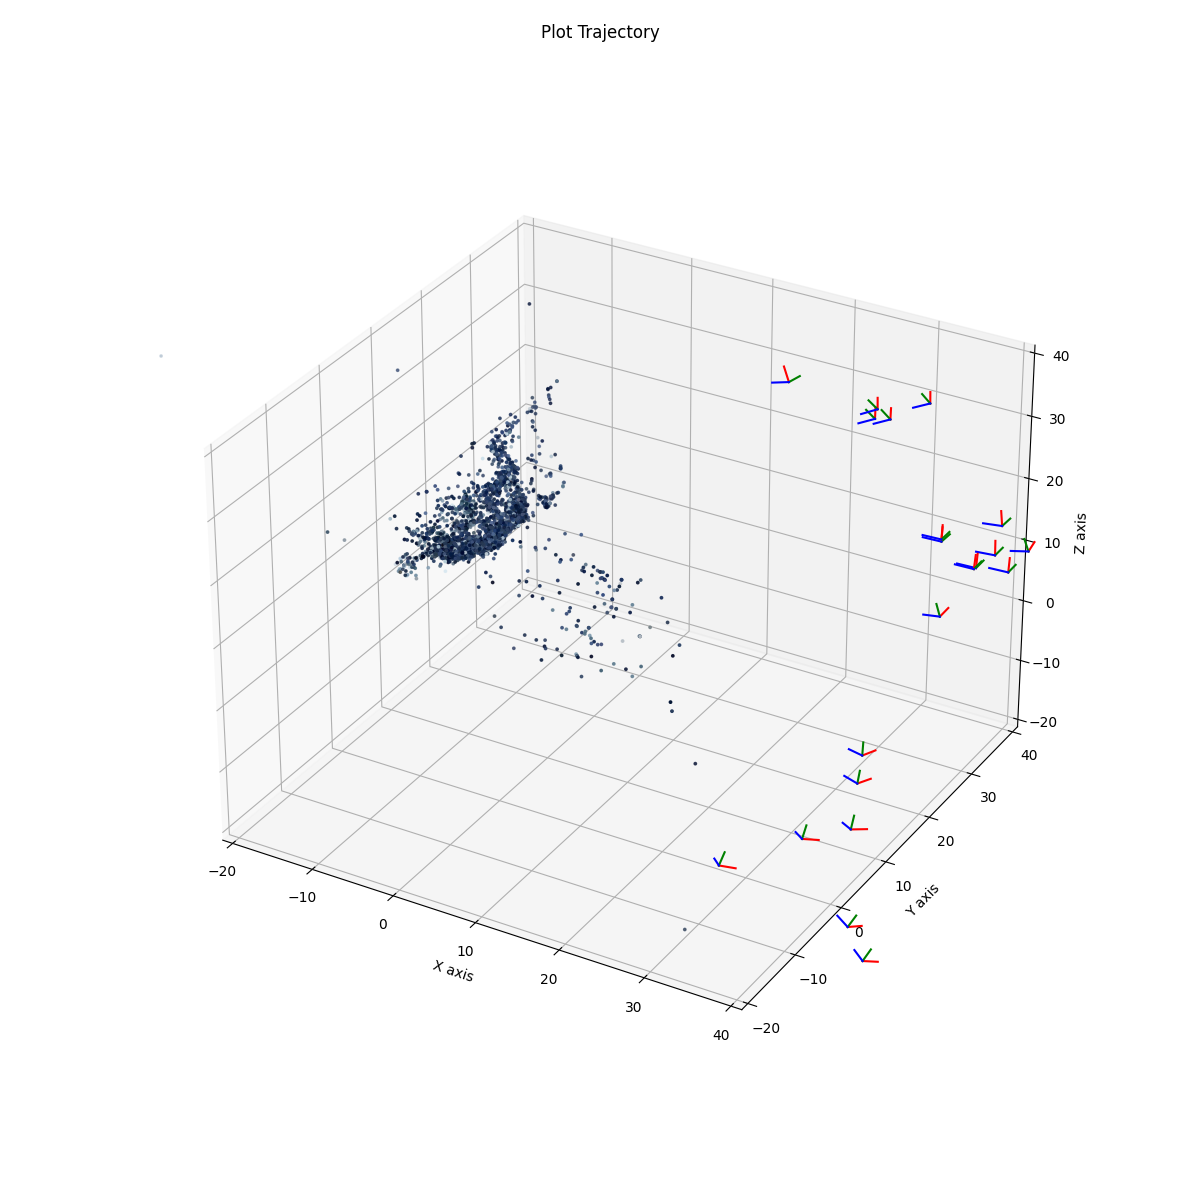

In [37]:
# %matplotlib qt
%matplotlib ipympl
import matplotlib.pyplot as plt 


fig = plt.figure(figsize = (12,12))
ax = fig.add_subplot(projection='3d')
# gtsam.utils.plot.plot_3d_points(1, result)
gtsam.utils.plot.plot_trajectory(1, result, scale=2)
gtsam.utils.plot.set_axes_equal(1)



xPts = [pt_cloud[0] for pt_cloud in pt_cloud_final]
yPts = [pt_cloud[1] for pt_cloud in pt_cloud_final]
zPts = [pt_cloud[2] for pt_cloud in pt_cloud_final]


ax.scatter(xPts, yPts, zPts, s=3, c = point_color_list/255.)
#gtsam.utils.plot.plot_3d_points(1, initial)
#gtsam.utils.plot.plot_3d_points(1, result, linespec = "r*", )


ax.set_xlim3d(-20, 40)
ax.set_ylim3d(-20, 40)
ax.set_zlim3d(-20, 40)


plt.show()